In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d


In [3]:
klin, plin = np.loadtxt('plins/abacus_pnw.txt', unpack=True)
#klin, plin = np.loadtxt('plins/abacus_pnw_bspline.txt', unpack=True)

In [4]:
Dz = 0.9483464322302488
fz = 0.5856

## Import Data

In [5]:
ncov = np.loadtxt('/pscratch/sd/s/sfschen/abacus_pvs/pvs/AbacusSummit_base_c000_z0.100_12.5_13.0_xins_rsd_cov.txt')

In [6]:
z = 0.1
logMmin, logMmax = 12.5, 13.0
sample = f'AbacusSummit_base_c000_ph000/halos/z{z:.3f}'

filebase = filebase = "pnms/"+"_".join(sample.split("_")[:3]) + '_' + sample.split("_")[-1][-6:] + '_' + f'{logMmin:.1f}' + '_' + f'{logMmax:.1f}'

In [7]:
p00s = 0
p01s = 0

for ii in range(25):
    p00s += 1./25 * np.loadtxt(filebase + f'_ph{ii:03}_pnms_v0_rsd.txt')
    p01s += 1./25 * np.loadtxt(filebase + f'_ph{ii:03}_pnms_v1_rsd.txt')

In [8]:
pv2s = []

for ii in range(25):
    pv2s += [np.loadtxt(filebase + f'_ph{ii:03}_pnms_v2_rsd.txt'),]

pv2s = np.array(pv2s)

In [9]:
pv2s_mean = np.mean(pv2s,axis=0)

p11s = pv2s_mean[:,[0,6,7,8,9,10]]
p02s = pv2s_mean[:,[0,1,2,3,4,5]]

sigma2_p11_0 = np.diag( np.cov(pv2s[:,:,6].T) )
sigma2_p11_2 = np.diag( np.cov(pv2s[:,:,8].T) )

sigma2_p02_0 = np.diag( np.cov(pv2s[:,:,1].T) )
sigma2_p02_2 = np.diag( np.cov(pv2s[:,:,3].T) )

In [10]:
pvs = []

for ii in range(25):
    pvs += [np.loadtxt(filebase + f'_ph{ii:03}_pnms_higher_rsd.txt'),]

pvs = np.array(pvs)

In [11]:
pvs_mean = np.mean(pvs, axis=0)

p12s = pvs_mean[:,[0,1,2,3,4,5]]
p22s = pvs_mean[:,[0,6,7,8,9,10]]

sigma2_p12_1 = np.diag( np.cov(pvs[:,:,2].T) )
sigma2_p12_3 = np.diag( np.cov(pvs[:,:,4].T) )

sigma2_p22_0 = np.diag( np.cov(pvs[:,:,6].T) )
sigma2_p22_2 = np.diag( np.cov(pvs[:,:,8].T) )

## Produce Smooth Curves

In [12]:
from scipy.interpolate import make_smoothing_spline


In [13]:
# Try to smooth hexadecapole
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

def make_smooth_curve_gp(x, fx, sigma2x, linear_scale=None, return_gp = False):

    # Define Standard Kernel
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=0.05)

    # Create the GP model
    if linear_scale is not None:
        sigma2[ks < linear_scale] *= 100 # force curve to go to linear theory below this number
        
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma2x, normalize_y=False, n_restarts_optimizer=9)

    # Fit
    gp.fit(x.reshape(-1, 1), fx)

    X_pred = x.reshape(-1, 1)
    y_pred, y_std = gp.predict(X_pred, return_std=True)

    if return_gp:
        return y_pred, y_std, gp
    else:
        return y_pred, y_std

In [14]:
ks = p00s[:,0]

#p0ks, p2ks, p4s = [savgol_filter(p00s[:,ii], 5, 3) for ii in [1, 3, 5]]

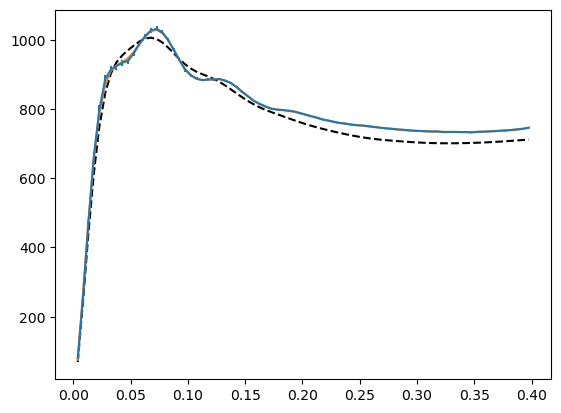

In [15]:
# P00_0
b1 = 1.06
sn = 1057.34
p0lin = np.interp(ks, klin,  (b1**2 + 2*fz*b1/3. + fz**2/5) * Dz**2 * plin + sn)

fk = p00s[:,1] / p0lin - 1
sigma2 = np.diag(ncov)[:80] / p0lin**2  / 5

plt.errorbar(ks, ks * p00s[:,1], yerr=np.sqrt(sigma2) * p0lin  * ks)

fkgp, fkgpstd, gp = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02, return_gp=True)

plt.plot(ks, ks * p0lin, 'k--')
plt.plot(ks, ks * p0lin * (1 + fkgp))


p00_0_gp = p0lin * (1 + fkgp)

In [16]:
gp.kernel_.get_params()

{'k1': 0.0456**2,
 'k2': RBF(length_scale=0.026),
 'k1__constant_value': 0.0020826550759759466,
 'k1__constant_value_bounds': (0.001, 1000.0),
 'k2__length_scale': 0.02596763309681141,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

(0.0, 700.0)

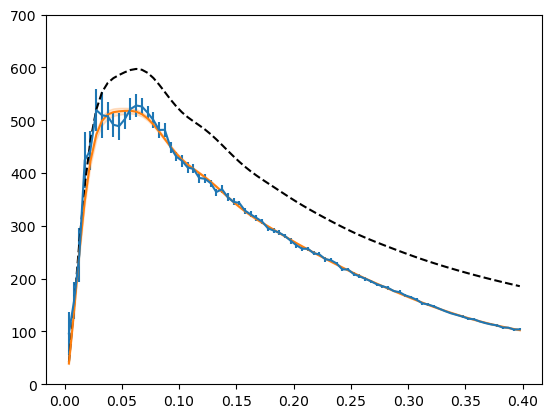

In [17]:
p2lin = np.interp(ks, klin,  (4*b1*fz/3 + 4*fz**2/7.) * Dz**2 * plin )

fk = p00s[:,3] / p2lin - 1
sigma2 = np.diag(ncov)[80:160] / p2lin**2 / 5

plt.errorbar(ks, ks * p00s[:,3], yerr=np.sqrt(sigma2) * p2lin * ks)

fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02)

plt.plot(ks, ks * p2lin, 'k--')
plt.plot(ks, ks * p2lin * (1 + fkgp),'C1')

plt.fill_between(ks, ks * p2lin * (1 + fkgp - fkgpstd), ks * p2lin * (1 + fkgp + fkgpstd), alpha=0.2,color='C1')




p00_2_gp = p2lin * (1 + fkgp)

plt.ylim(0,700)

(-50.0, 100.0)

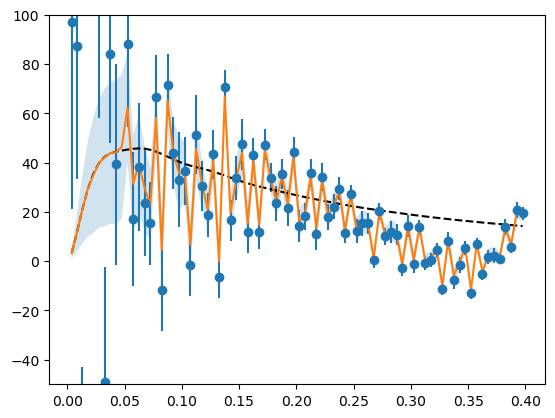

In [18]:
p4lin = np.interp(ks, klin,  8*fz**2/35 * Dz**2 * plin )

fk = p00s[:,5] / p4lin - 1
sigma2 = np.diag(ncov)[160:240] / p4lin**2 / 5

plt.errorbar(ks, ks * p00s[:,5], yerr=np.sqrt(sigma2) * p4lin * ks, fmt='o')

fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.05)

plt.plot(ks, ks * p4lin, 'k--')
plt.plot(ks, ks * p4lin * (1 + fkgp))

plt.fill_between(ks, ks * p4lin * (1 + fkgp - fkgpstd), ks * p4lin * (1 + fkgp + fkgpstd), alpha=0.2)


p00_4_gp = p4lin * (1 + fkgp)

plt.ylim(-50,100)


(-100.0, 700.0)

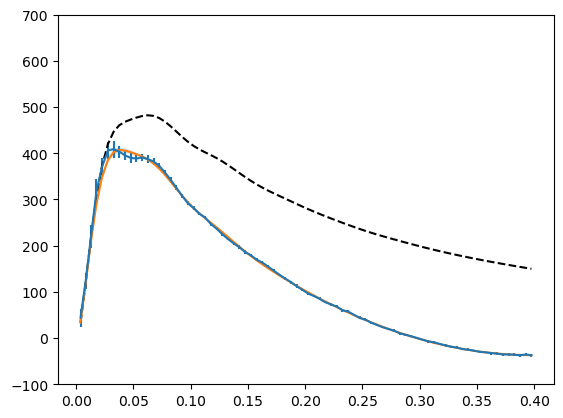

In [19]:
p01_1_lin = np.interp(ks, klin,  - (b1*fz + (3*fz**2)/5) * Dz**2 * plin / klin )

fk = p01s[:,2] / p01_1_lin - 1
sigma2 = np.diag(ncov)[240:320] / p01_1_lin**2 / 5

plt.errorbar(ks, -ks**2 * p01s[:,2], yerr=np.sqrt(sigma2) * np.abs(p01_1_lin) * ks**2)


fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.05)

plt.plot(ks, -ks**2 * p01_1_lin, 'k--')
plt.plot(ks, -ks**2 * p01_1_lin * (1 + fkgp))

plt.fill_between(ks, -ks**2 * p01_1_lin * (1 + fkgp - fkgpstd), -ks**2 * p01_1_lin * (1 + fkgp + fkgpstd), alpha=0.2)


p01_1_gp = p01_1_lin * (1 + fkgp)

plt.ylim(-100,700)

(-10.0, 100.0)

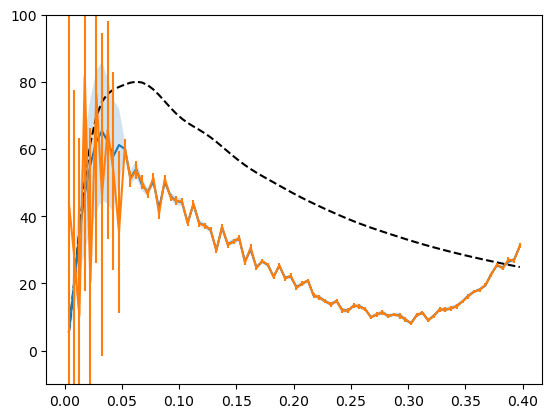

In [20]:
p01_3_lin = np.interp(ks, klin,  - 2*fz**2/5 * Dz**2 * plin / klin )

fk = p01s[:,4] / p01_3_lin - 1
sigma2 = np.diag(ncov)[320:400] / p01_1_lin**2  / 5
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.05)

plt.plot(ks, -ks**2 * p01_3_lin, 'k--')
plt.plot(ks, -ks**2 * p01_3_lin * (1 + fkgp))

plt.fill_between(ks, -ks**2 * p01_3_lin * (1 + fkgp - fkgpstd), -ks**2 * p01_3_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, -ks**2 * p01s[:,4], yerr=np.sqrt(sigma2) * np.abs(p01_3_lin) * ks**2)

p01_3_gp = p01_3_lin * (1 + fkgp)

plt.ylim(-10,100)

(0.0, 0.3)

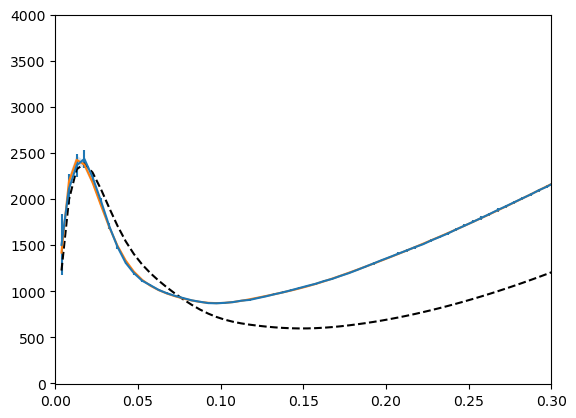

In [21]:
p11_0_lin = np.interp(ks, klin,  fz**2/3 * Dz**2 * plin / klin**2 + 12361 )

fk = p11s[:,1] / p11_0_lin - 1
sigma2 = sigma2_p11_0 / p11_0_lin**2 / 5
plt.errorbar(ks, ks**2 * p11s[:,1], yerr=np.sqrt(sigma2) * np.abs(p11_0_lin) * ks**2)


fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02)

plt.plot(ks, ks**2 * p11_0_lin, 'k--')
plt.plot(ks,ks**2 * p11_0_lin * (1 + fkgp))

plt.fill_between(ks, ks**2 * p11_0_lin * (1 + fkgp - fkgpstd), ks**2 * p11_0_lin * (1 + fkgp + fkgpstd), alpha=0.2)


p11_0_gp = p11_0_lin * (1 + fkgp)

plt.ylim(-10,4000)

plt.xlim(0,0.3)

(0.0, 0.3)

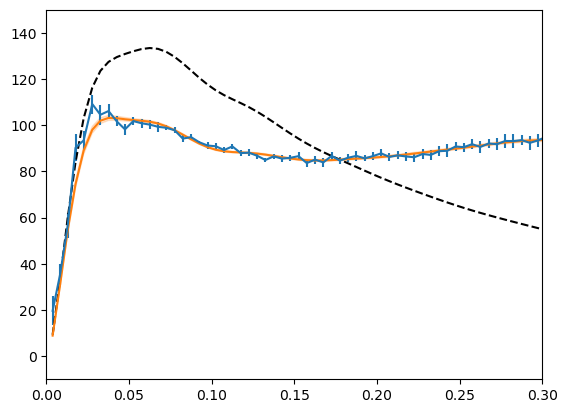

In [22]:
p11_2_lin = np.interp(ks, klin,  2*fz**2/3 * Dz**2 * plin / klin**2 )

fk = p11s[:,3] / p11_2_lin - 1
sigma2 = sigma2_p11_2 / p11_2_lin**2 / 5

plt.errorbar(ks, ks**3 * p11s[:,3], yerr= np.sqrt(sigma2) * np.abs(p11_2_lin) * ks**3)


fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02)

plt.plot(ks, ks**3 * p11_2_lin, 'k--')
plt.plot(ks,ks**3 * p11_2_lin * (1 + fkgp))

plt.fill_between(ks, ks**3 * p11_2_lin * (1 + fkgp - fkgpstd), ks**3 * p11_2_lin * (1 + fkgp + fkgpstd), alpha=0.2, color='C1')


p11_2_gp = p11_2_lin * (1 + fkgp)

plt.ylim(-10,150)

plt.xlim(0,0.3)

(0.0, 0.3)

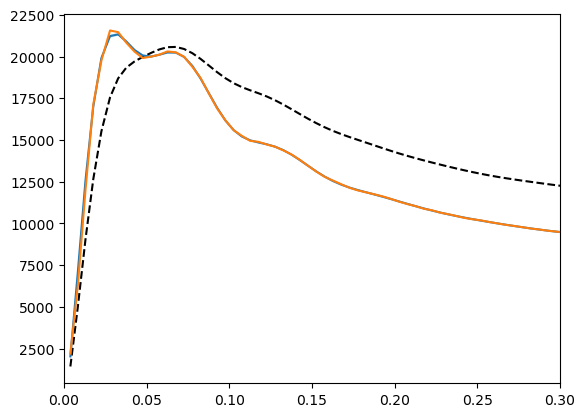

In [23]:
p02_0_lin = np.interp(ks, klin, 70 * Dz**2 * (2*b1*fz/3 + fz**2/5) * plin + 13806 )

kpow = 1

fk = p02s[:,1] / p02_0_lin - 1
sigma2 = sigma2_p02_0 / p02_0_lin**2 / 25
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.01)

plt.plot(ks, ks**kpow * p02_0_lin, 'k--')
plt.plot(ks,ks*kpow * p02_0_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p02_0_lin * (1 + fkgp - fkgpstd), ks**kpow * p02_0_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, ks**kpow * p02s[:,1], yerr=0*np.sqrt(sigma2) * np.abs(p02_0_lin) * ks**kpow)

p02_0_gp = p02_0_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

(0.0, 0.3)

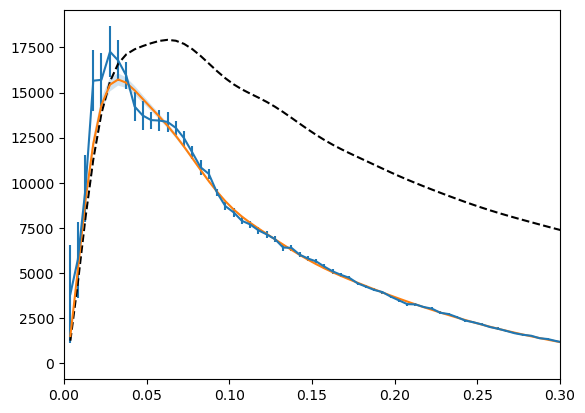

In [24]:
p02_2_lin = np.interp(ks, klin, 30 * Dz**2 * (4*b1*fz/3 + 4*fz**2/7.)* plin)

kpow = 1

fk = p02s[:,3] / p02_2_lin - 1
sigma2 = sigma2_p02_2 / p02_2_lin**2 / 5

plt.errorbar(ks, ks**kpow * p02s[:,3], yerr=np.sqrt(sigma2) * np.abs(p02_2_lin) * ks)

fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02)

plt.plot(ks, ks**kpow * p02_2_lin, 'k--')
plt.plot(ks,ks*kpow * p02_2_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p02_2_lin * (1 + fkgp - fkgpstd), ks**kpow * p02_2_lin * (1 + fkgp + fkgpstd), alpha=0.2)


p02_2_gp = p02_2_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

(0.0, 0.3)

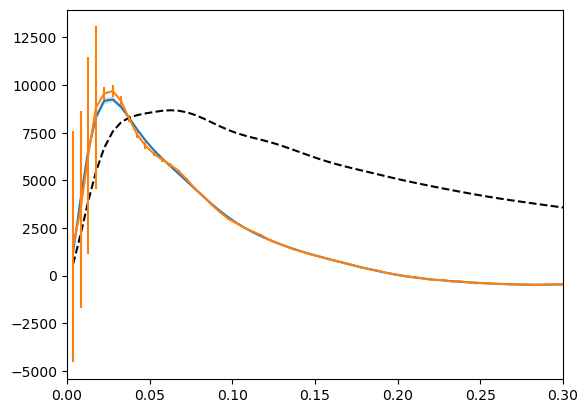

In [25]:
p12_1_lin = np.interp(ks, klin, 18 * (b1*fz + (3*fz**2)/5) * Dz**2 * plin / klin )

kpow = 2

fk = p12s[:,2] / p12_1_lin - 1
sigma2 = sigma2_p12_1 / p12_1_lin**2 / 5
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.02)

plt.plot(ks, ks**kpow * p12_1_lin, 'k--')
plt.plot(ks, ks**kpow * p12_1_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p12_1_lin * (1 + fkgp - fkgpstd), ks**kpow * p12_1_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, ks**kpow * p12s[:,2], yerr= np.sqrt(sigma2) * np.abs(p12_1_lin) * ks**kpow)

p12_1_gp = p12_1_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

(0.0, 0.3)

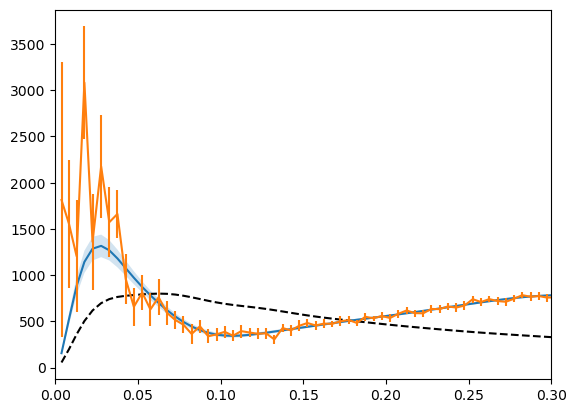

In [26]:
p12_3_lin = np.interp(ks, klin, 10 * 2*fz**2/5 * Dz**2 * plin / klin )

kpow = 2

fk = p12s[:,4] / p12_3_lin - 1
sigma2 = sigma2_p12_3 / p12_3_lin**2 / 5
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = None)

plt.plot(ks, ks**kpow * p12_3_lin, 'k--')
plt.plot(ks, ks**kpow * p12_3_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p12_3_lin * (1 + fkgp - fkgpstd), ks**kpow * p12_3_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, ks**kpow * p12s[:,4], yerr=np.sqrt(sigma2) * np.abs(p12_3_lin) * ks**kpow)

p12_3_gp = p12_3_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

/global/homes/s/sfschen/.conda/envs/pcobaya/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(0.0, 0.3)

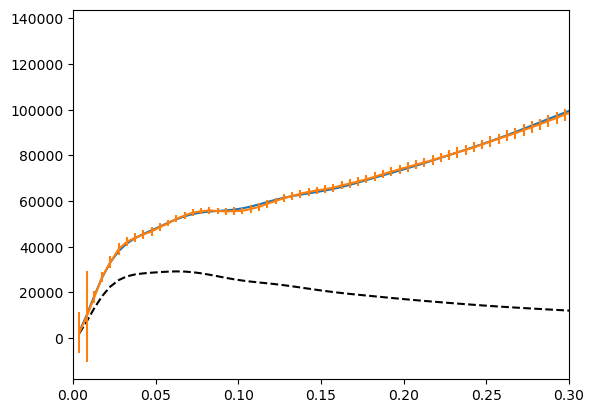

In [27]:
p22_0_lin = np.interp(ks, klin, 45*plin/klin)

kpow = 2

fk = p22s[:,1] / p22_0_lin - 1
sigma2 = sigma2_p22_0 / p22_0_lin**2
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.01)

plt.plot(ks, ks**kpow * p22_0_lin, 'k--')
plt.plot(ks,ks**kpow * p22_0_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p22_0_lin * (1 + fkgp - fkgpstd), ks**kpow * p22_0_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, ks**kpow * p22s[:,1], yerr=np.sqrt(sigma2) * np.abs(p22_0_lin) * ks**kpow)

p22_0_gp = p22_0_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

(0.0, 0.3)

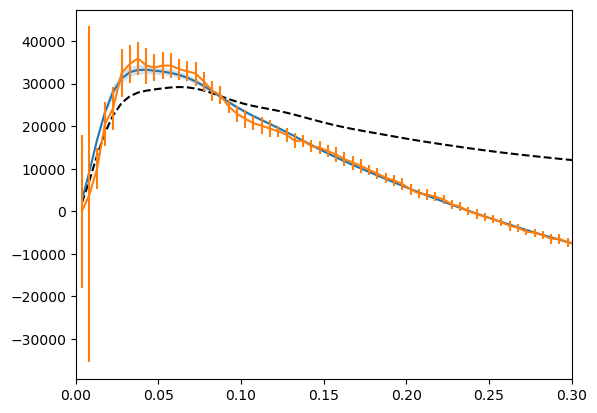

In [28]:
p22_2_lin = np.interp(ks, klin, 45*plin/klin  )

kpow = 2

fk = p22s[:,3] / p22_2_lin - 1
sigma2 = sigma2_p22_2 / p22_2_lin**2
fkgp, fkgpstd = make_smooth_curve_gp(ks, fk, sigma2, linear_scale = 0.01)

plt.plot(ks, ks**kpow * p22_2_lin, 'k--')
plt.plot(ks,ks**kpow * p22_2_lin * (1 + fkgp))

plt.fill_between(ks, ks**kpow * p22_2_lin * (1 + fkgp - fkgpstd), ks**kpow * p22_2_lin * (1 + fkgp + fkgpstd), alpha=0.2)

plt.errorbar(ks, ks**kpow * p22s[:,3], yerr=np.sqrt(sigma2) * np.abs(p22_2_lin) * ks**kpow)

p22_2_gp = p22_2_lin * (1 + fkgp)

#plt.ylim(-10,4000)

plt.xlim(0,0.3)

## Make Covariance

In [29]:
from scipy.special import eval_legendre

mus, ws = np.polynomial.legendre.leggauss(8)

def compute_spectrum_from_multipoles(mus, multipoles):
    
    ret = 0
    
    for ell, multipole in multipoles:
        ret += eval_legendre(ell, mus)[:,None] * multipole[None,:]
        
    return ret

In [30]:
p00_0 = p00s[:,1]
p00_2 = p00s[:,3]
p00_4 = p00s[:,5]

p00 = [(0, p00_0_gp),(2, p00_2_gp), (4, p00_4_gp)]
p00_noisy = [(0, p00_0),(2, p00_2), (4, p00_4)]

p01_1 = p01s[:,2]
p01_3 = p01s[:,4]

p01 = [(1, p01_1_gp),(3, p01_3_gp)]
p01_noisy = [(1, p01_1),(3, p01_3)]

p11_0 = p11s[:,1]
p11_2 = p11s[:,3]
p11_4 = p11s[:,5]

p11 = [(0, p11_0_gp),(2, p11_2_gp)]
p11_noisy = [(0, p11_0),(2, p11_2)]

p02_0 = p02s[:,1]
p02_2 = p02s[:,3]
p02_4 = p02s[:,5]

p02 = [(0, p02_0_gp),(2, p02_2_gp)]
p02_noisy = [(0, p02_0),(2, p02_2)]

p22_0 = p22s[:,1]
p22_2 = p22s[:,3]
p22_4 = p22s[:,5]

p22 = [(0, p22_0_gp),(2, p22_2_gp)]
p22_noisy = [(0, p22_0),(2, p22_2)]

p12_1 = p12s[:,2]
p12_3 = p12s[:,4]

p12 = [(1, p12_1_gp),(3, p12_3_gp)]
p12_noisy = [(1, p12_1),(3, p12_3)]

In [31]:
# First Try For One k
observables = {0: (0,2,4), 1: (1,3), 2: (0,2)}

#observables = {0: (0,), 1: (1,3), 2: (0,2)}


pairs = {'00': [(p00, p00, 2)],\
         '01': [(p00, p01, 4)],\
         '10': [(p00, p01, 4)],\
         '11': [(p00, p11, 4), (p01, p01, 4)],\
         '02': [(p00,p02,4),(p01,p01,-4)],\
         '12': [(p02,p01,4),(p00,p12,-4),(p11,p01,-8)],\
         '22': [(p00,p22,4),(p02,p02,4),(p11,p11,8),(p01,p12,16)]}

pairs_noisy = {'00': [(p00_noisy, p00_noisy, 2)],\
         '01': [(p00_noisy, p01_noisy, 4)],\
         '10': [(p00_noisy, p01_noisy, 4)],\
         '11': [(p00_noisy, p11_noisy, 4), (p01_noisy, p01_noisy, 4)],\
         '02': [(p00_noisy,p02_noisy,4),(p01_noisy,p01_noisy,-4)],\
         '12': [(p02_noisy,p01_noisy,4),(p00_noisy,p12_noisy,-4),(p11_noisy,p01_noisy,-8)],\
         '22': [(p00_noisy,p22_noisy,4),(p02_noisy,p02_noisy,4),(p11_noisy,p11_noisy,8),(p01_noisy,p12_noisy,16)]}

In [32]:
#pairs['22'] = [(p02,p02,4),(p11,p11,8),\
#               (p00,p22,4)]
#pairs_noisy['22'] = [(p02_noisy,p02_noisy,4),(p11_noisy,p11_noisy,8),\
#                     (p00_noisy,p22_noisy,4)]

In [33]:
dk = 0.005
kcents = np.arange(0, 0.4, dk) + dk/2

Vobs = (2e3)**3
Nks =  4*np.pi * 1./3 * ( (kcents + dk/2)**3 - (kcents - dk/2)**3 ) * Vobs/(2*np.pi)**3

In [34]:
obs_indices = observables.keys()

Nvec = 0
for key in observables.keys():
    Nvec += len(observables[key])

cov = np.zeros((Nvec*len(kcents), Nvec*len(kcents)))

for kk, kcent in enumerate(kcents):

    ii = kk
    
    Nk = 4*np.pi * 1./3 * ( (kcent + dk/2)**3 - (kcent - dk/2)**3 ) * Vobs/(2*np.pi)**3
    
    for n in obs_indices:
    
        ells = observables[n]
    
        for ell in ells:
    
            jj = kk
        
            for m in obs_indices:
                ellsp = observables[m]

                Cfuncmu = 0
                if n <= m:
                    pair_ij = str(n) + str(m)
                else:
                    pair_ij = str(m) + str(n)
            
                for p1, p2, coeff in pairs[pair_ij]:
                    prod = compute_spectrum_from_multipoles(mus, p1) * compute_spectrum_from_multipoles(mus, p2)
                    prod = interp1d(ks, prod, kind='cubic',fill_value=0,bounds_error=False)(kcent)
                    Cfuncmu += coeff * prod
            
                for ellp in ellsp:
                
                    cov[ii,jj] = (2*ell+1)*(2*ellp+1)/(2*Nk) * np.sum(ws *\
                                                             Cfuncmu * \
                                                             eval_legendre(ell, mus) * eval_legendre(ellp, mus))
                
                    jj += len(kcents)
            
        
            ii += len(kcents)

In [35]:
def compute_diagonal_cov(observables, pairs):
    obs_indices = observables.keys()

    Nvec = 0
    for key in observables.keys():
        Nvec += len(observables[key])

    cov = np.zeros((Nvec*len(kcents), Nvec*len(kcents)))

    for kk, kcent in enumerate(kcents):

        ii = kk
    
        Nk = 4*np.pi * 1./3 * ( (kcent + dk/2)**3 - (kcent - dk/2)**3 ) * Vobs/(2*np.pi)**3
    
        for n in obs_indices:
    
            ells = observables[n]
    
            for ell in ells:
    
                jj = kk
        
                for m in obs_indices:
                    ellsp = observables[m]

                    Cfuncmu = 0
                    if n <= m:
                        pair_ij = str(n) + str(m)
                    else:
                        pair_ij = str(m) + str(n)
            
                    for p1, p2, coeff in pairs[pair_ij]:
                        prod = compute_spectrum_from_multipoles(mus, p1) * compute_spectrum_from_multipoles(mus, p2)
                        prod = interp1d(ks, prod, kind='cubic',fill_value=(prod[:,0],prod[:,-1]),bounds_error=False)(kcent)
                        Cfuncmu += coeff * prod
            
                    for ellp in ellsp:
                
                        cov[ii,jj] = (2*ell+1)*(2*ellp+1)/(2*Nk) * np.sum(ws *\
                                                             Cfuncmu * \
                                                             eval_legendre(ell, mus) * eval_legendre(ellp, mus))
                
                        jj += len(kcents)
            
        
                ii += len(kcents)
    return cov

In [36]:
cov_noisy = compute_diagonal_cov(observables, pairs_noisy)
cov = compute_diagonal_cov(observables, pairs)

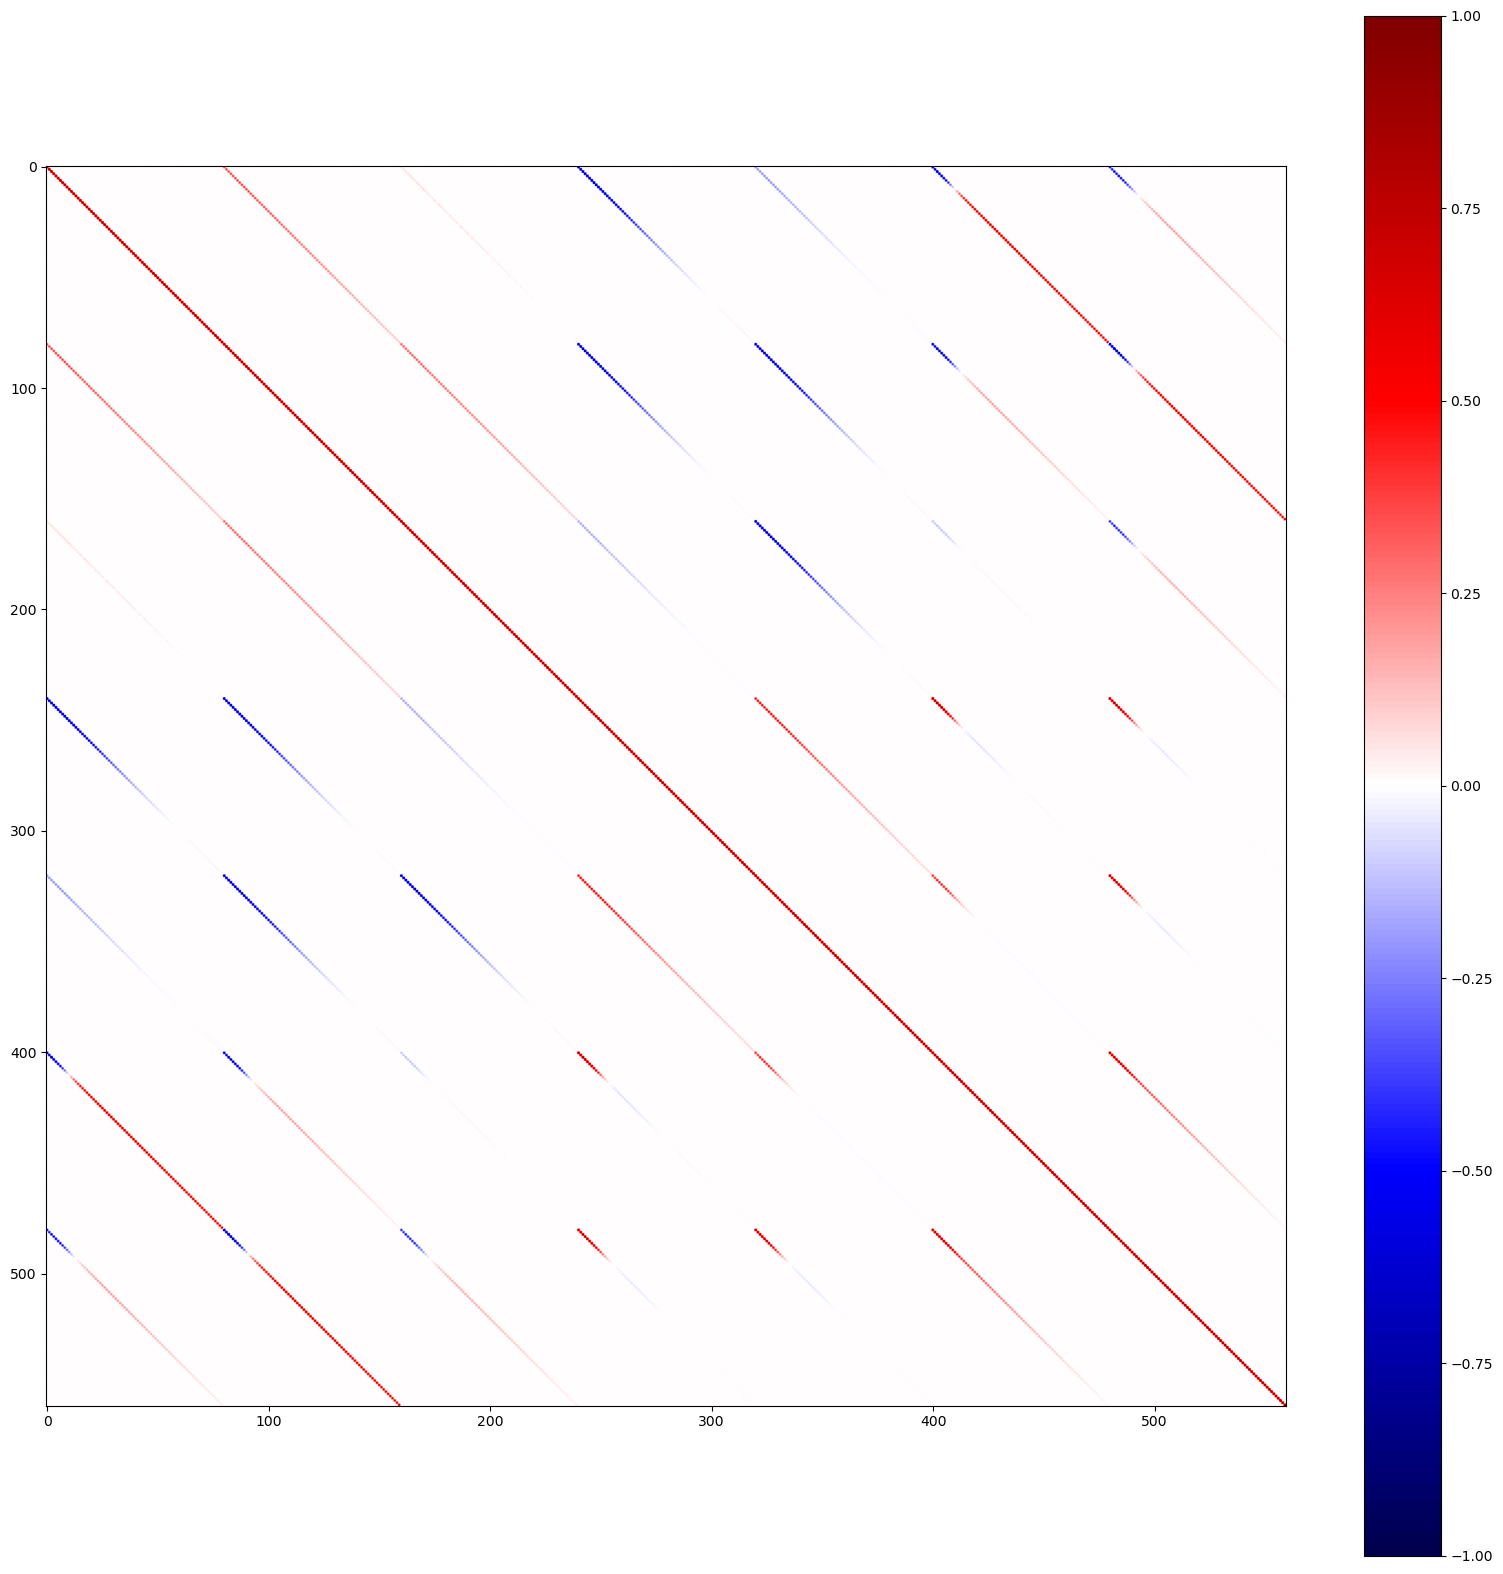

In [37]:
errs = np.diag(cov)**0.5

corr = cov / errs[:,None] / errs[None,:]

plt.figure(figsize=(20,20))

plt.imshow( corr, vmin=-1, vmax=1, cmap='seismic')

plt.colorbar()

In [38]:
kmaxplot = 0.3

0
1
2


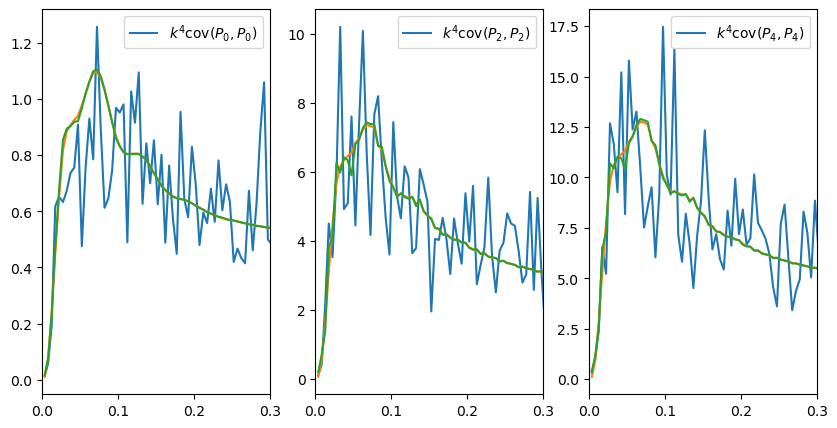

In [39]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((0,0),(1,1),(2,2))
labels=[r'cov($P_0,P_0$)',r'cov($P_2,P_2$)',r'cov($P_4,P_4$)']
kpow = 4

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols])

    #rat = ncov[rows,cols] / cov[rows,cols]
    #rat_smoothed = savgol_filter(rat, 40, 5)

    #plt.plot(ks, ks**kpow * rat_smoothed * cov[rows,cols], 'k--')

    
    plt.xlim(0,kmaxplot)
    plt.legend(loc='upper right')

0
1
2


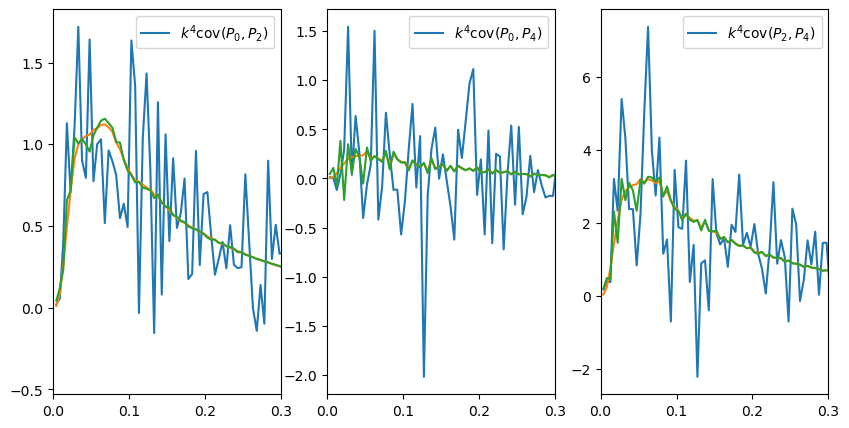

In [40]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((0,1),(0,2),(1,2))
labels=[r'cov($P_0,P_2$)',r'cov($P_0,P_4$)',r'cov($P_2,P_4$)']
kpow = 4

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols])
    
    plt.xlim(0,kmaxplot)
    plt.legend(loc='upper right')

0
1
2


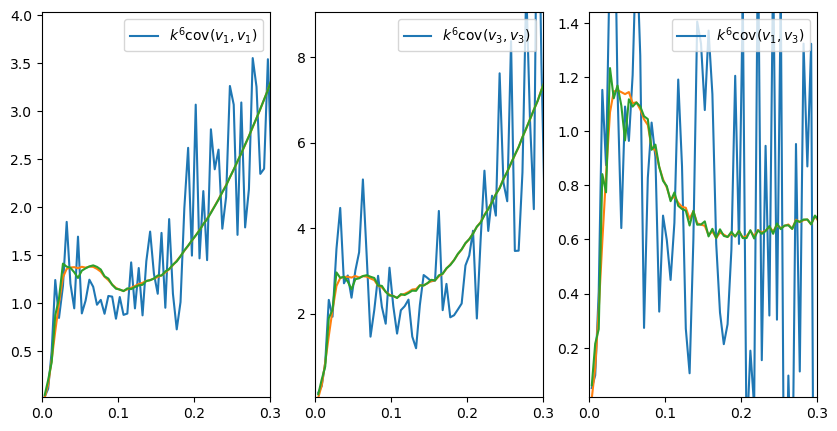

In [41]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((3,3),(4,4),(3,4))
labels=[r'cov($v_1,v_1$)',r'cov($v_3,v_3$)',r'cov($v_1,v_3$)']
kpow = 6

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols])

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    plt.ylim(1.25*ymin,1.25*ymax)
    plt.legend(loc='upper right')

0
1
2


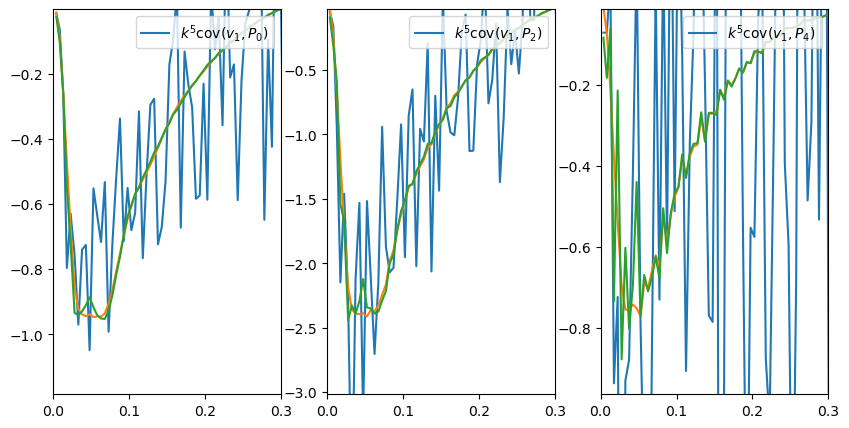

In [42]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((3,0),(3,1),(3,2))
labels=[r'cov($v_1,P_0$)',r'cov($v_1,P_2$)',r'cov($v_1,P_4$)']
kpow = 5

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols])

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    plt.ylim(1.25*ymin,1.5*ymax)
    plt.legend(loc='upper right')

0
1
2


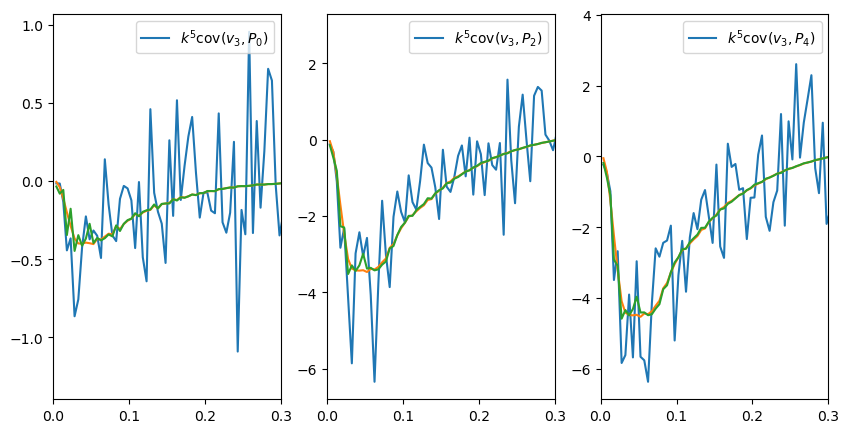

In [43]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((4,0),(4,1),(4,2))
labels=[r'cov($v_3,P_0$)',r'cov($v_3,P_2$)',r'cov($v_3,P_4$)']
kpow = 5

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols])

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,0.3)
    #plt.ylim(1.25*ymin,1.5*ymax)
    plt.legend(loc='upper right')

0
1
2


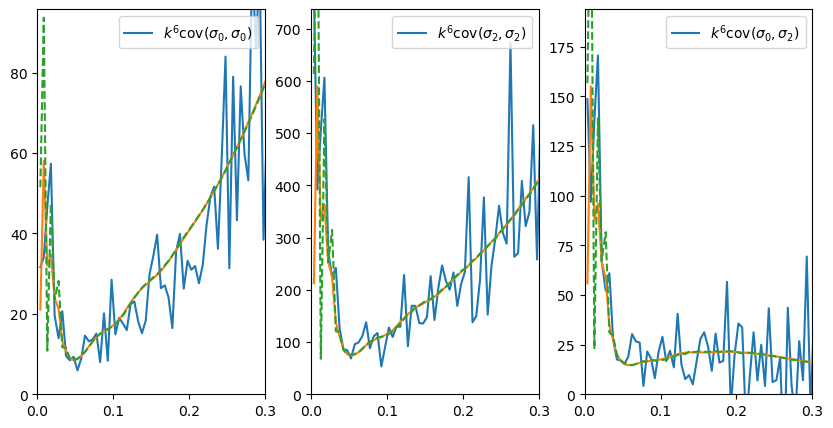

In [44]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((5,5),(6,6),(5,6))
labels=[r'cov($\sigma_0,\sigma_0$)',r'cov($\sigma_2,\sigma_2$)',r'cov($\sigma_0,\sigma_2$)']
kpow = 6

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols],'--')

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,0.3)
    plt.ylim(0*ymin,1.25*ymax)
    plt.legend(loc='upper right')

0
1
2


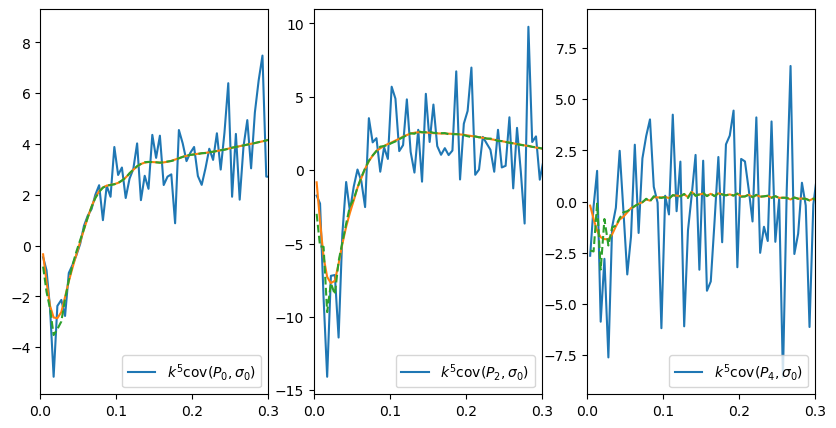

In [45]:
# These are the power spectrum multipoles
plt.figure(figsize=(10,5))

pairs=((0,5),(1,5),(2,5))
labels=[r'cov($P_0,\sigma_0$)',r'cov($P_2,\sigma_0$)',r'cov($P_4,\sigma_0$)']
kpow = 5

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols],'--')

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    #plt.ylim(1.25*ymin,4*ymax)
    plt.legend(loc='lower right')

0
1
2


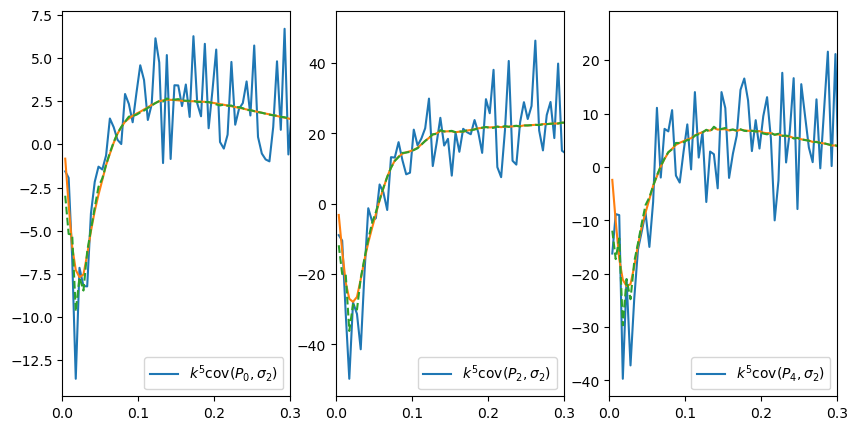

In [46]:
plt.figure(figsize=(10,5))

pairs=((0,6),(1,6),(2,6))
labels=[r'cov($P_0,\sigma_2$)',r'cov($P_2,\sigma_2$)',r'cov($P_4,\sigma_2$)']
kpow = 5

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols],'--')

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    #plt.ylim(1.25*ymin,4*ymax)
    plt.legend(loc='lower right')

0
1
2


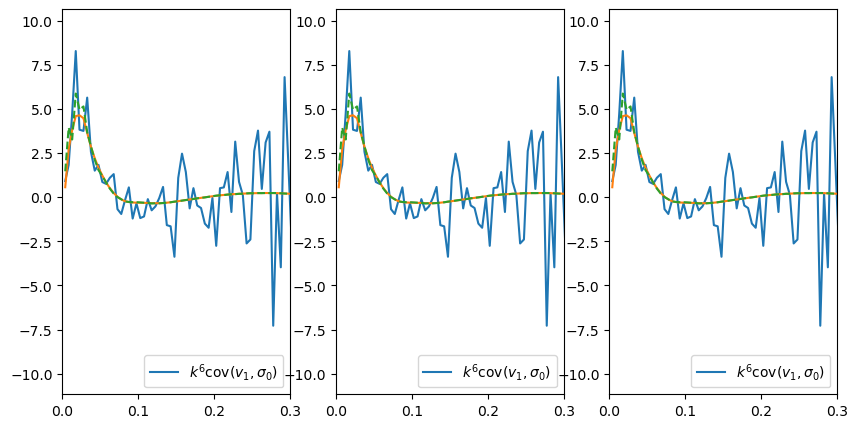

In [47]:
plt.figure(figsize=(10,5))

pairs=((3,5),(3,5),(3,5))
labels=[r'cov($v_1,\sigma_0$)',r'cov($v_1,\sigma_0$)',r'cov($v_1,\sigma_0$)']
kpow = 6

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols],'--')

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    #plt.ylim(1.25*ymin,4*ymax)
    plt.legend(loc='lower right')

0
1
2


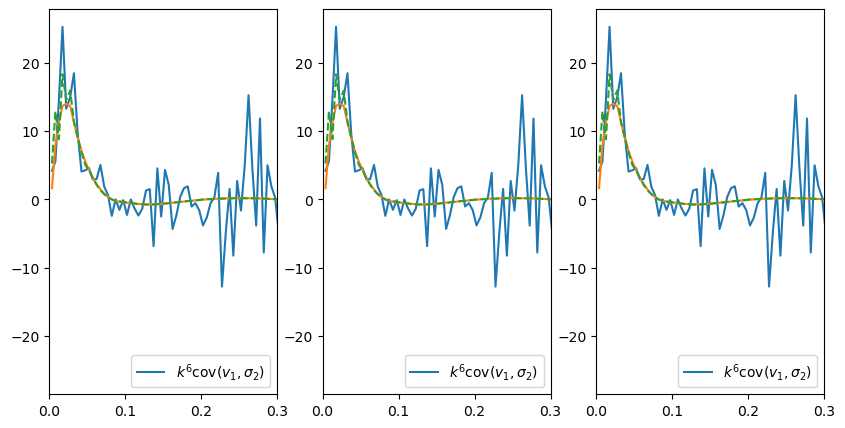

In [48]:
plt.figure(figsize=(10,5))

pairs=((3,6),(3,6),(3,6))
labels=[r'cov($v_1,\sigma_2$)',r'cov($v_1,\sigma_2$)',r'cov($v_1,\sigma_2$)']
kpow = 6

for nn, pair in enumerate(pairs):

    print(nn)
    
    plt.subplot(1,len(pairs),nn+1)

    rows = pair[0]*len(kcents) + np.arange(len(kcents))
    cols = pair[1]*len(kcents) + np.arange(len(kcents))

    label= r'$k^{%d}$'%(kpow) + labels[nn]
    plt.plot(ks, ks**kpow * ncov[rows,cols],label=label)
    plt.plot(ks, ks**kpow * cov[rows,cols])
    plt.plot(ks, ks**kpow * cov_noisy[rows,cols],'--')

    ymax = np.max( (ks**kpow * cov[rows,cols])[ks < 0.3] )
    ymin = np.min( (ks**kpow * cov[rows,cols])[ks < 0.3] )

    plt.xlim(0,kmaxplot)
    #plt.ylim(1.25*ymin,4*ymax)
    plt.legend(loc='lower right')

In [49]:
ks.shape

(80,)

In [50]:
# Make Plots
stds = np.sqrt(np.diag(cov))
corr = cov / np.outer(stds, stds)

stds_n = np.sqrt(np.diag(ncov))
corr_n = ncov / np.outer(stds, stds)

stds_noisy = np.sqrt(np.diag(cov_noisy))
corr_noisy = cov_noisy / np.outer(stds, stds)

# Plot setup

Nvec = 80
inds = [0, 1, 3, 5]
kpows = [3, 3, 4, 5]

names = [r'$P_0$',r'$P_2$',r'$v_1$',r'$\sigma_0^2$']

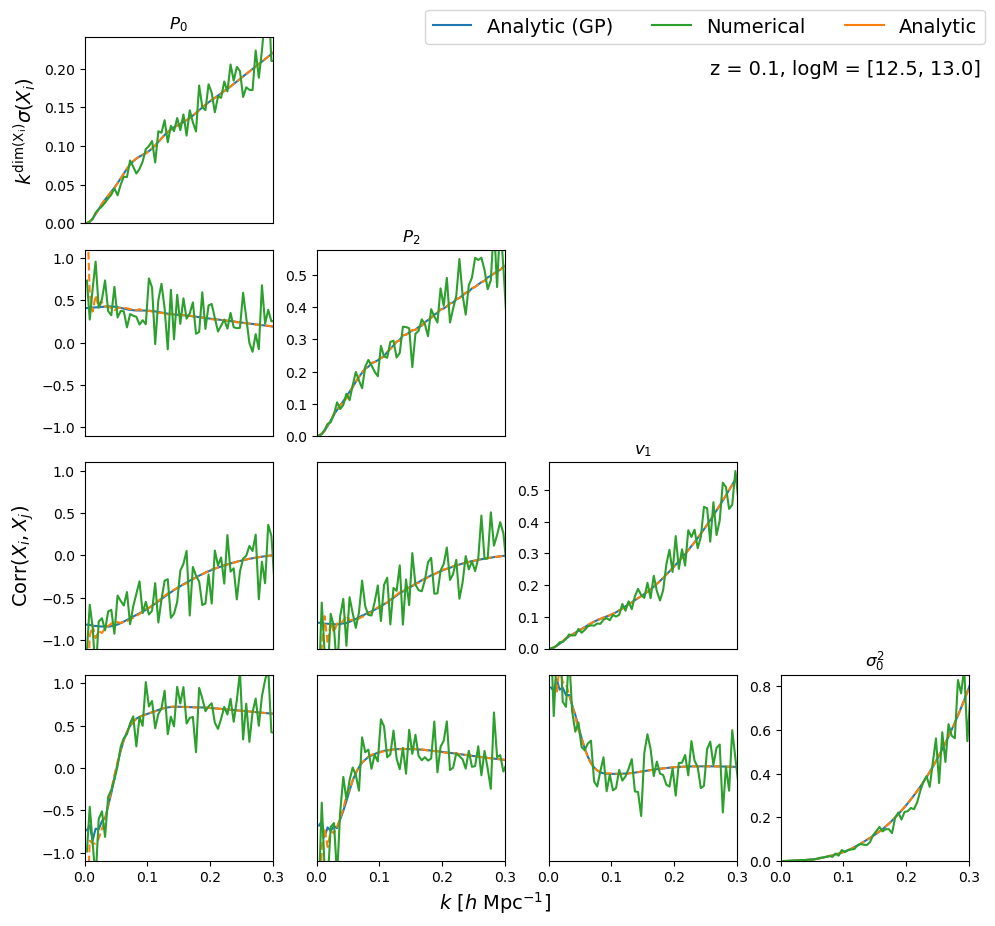

In [51]:
# Plot setup
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# For legend: plot once with labels and store handles
line1, = axes[0, 0].plot([], [], label='Analytic (GP)', color='C0')
line2, = axes[0, 0].plot([], [], label='Analytic', color='C1')
line3, = axes[0, 0].plot([], [], label='Numerical', color='C2')

# Loop through the lower triangle
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        if i < j:
            ax.axis('off')  # upper triangle: leave blank
        elif i == j:
            # Diagonal: predicted std dev
            ind = inds[i]
            kpow = kpows[i]
            ax.plot(ks, ks**(kpow) *  stds[(ind*Nvec):((ind+1)*Nvec)], color='C0')
            ax.plot(ks, ks**(kpow) *  stds_noisy[(ind*Nvec):((ind+1)*Nvec)], '--', color='C1')
            ax.plot(ks, ks**(kpow) *  stds_n[(ind*Nvec):((ind+1)*Nvec)], color='C2')
            ax.set_title(names[i])

            yplot = (ks**(kpow) *  stds[(ind*Nvec):((ind+1)*Nvec)])[ks < 0.3]
            ymin, ymax = np.min(yplot), np.max(yplot)

            ax.set_ylim(0, 1.1 * ymax)
            
        else:
            indX, indY = inds[i], inds[j]
            rows = indX * Nvec + np.arange(Nvec)
            cols = indY * Nvec + np.arange(Nvec)
            ax.plot(ks, corr[rows, cols], color='C0')
            ax.plot(ks, corr_noisy[rows, cols],'--', color='C1')
            ax.plot(ks, corr_n[rows, cols], color='C2')
            ax.set_ylim(-1.1, 1.1)
        
        ax.set_xlim([0.0, 0.3])
        if i != len(inds) - 1:
            ax.set_xticks([])
        if j > 0 and i != j:
            ax.set_yticks([])

axes[0,0].set_ylabel(r'$k^{\rm{dim}(X_i)} \sigma(X_i)$', fontsize=14)

axes[2,0].set_ylabel(r'Corr$(X_i,X_j)$', fontsize=14)

# Add global legend
fig.legend(handles=[line1, line3, line2],
           loc='upper right', ncol=3, fontsize=14,\
          bbox_to_anchor=(1.0, 0.95))

# Add global x-axis label
fig.text(0.5, 0.04, r'$k$ [$h$ Mpc$^{-1}$]', ha='center', fontsize=14)
fig.text(0.85, 0.875, 'z = 0.1, logM = [12.5, 13.0]', ha='center', fontsize=14)

plt.tight_layout(rect=[0, 0.05, 1, 0.95], w_pad =0.05, h_pad=0.05)  # leave space for legend

plt.savefig('Figures/cov_z_0.1_logM_12.5_13.0.pdf')

In [56]:
Nvec

80

## Check Covariance k-by-k

In [57]:
ev_array = []

for ii in range((len(ks))):
    inds = [ii + nn * len(ks) for nn in range(7)]
    #inds = [ii + nn * len(ks) for nn in [0, 1, 3, 4, 5, 6 ]]

    #inds = [ii + nn * len(ks) for nn in [0, 1, 2, 3, 4]]
    
    indx, indy = np.ix_(inds,inds)

    covk = 1.0 * cov[indx,indy]

    errk = np.diag(covk)**0.5
    corrk = covk / errk[:,None] / errk[None,:]

    evals = np.linalg.eigvalsh(corrk)

    if ii < 20:
        print(ii, '%.3f'%(ks[ii]), ['%.1e'%(ev) for ev in evals])

    ev_array += [evals]

ev_array = np.array(ev_array)

0 0.004 ['3.8e-03', '9.0e-03', '8.8e-02', '2.0e-01', '5.2e-01', '1.5e+00', '4.7e+00']
1 0.008 ['4.8e-03', '9.2e-03', '9.9e-02', '3.2e-01', '5.2e-01', '1.5e+00', '4.6e+00']
2 0.013 ['-1.2e-01', '-4.7e-03', '3.4e-02', '6.1e-02', '5.1e-01', '1.5e+00', '5.0e+00']
3 0.018 ['8.2e-03', '8.9e-03', '7.2e-02', '2.2e-01', '5.1e-01', '1.5e+00', '4.7e+00']
4 0.023 ['1.3e-03', '6.2e-03', '6.5e-02', '1.6e-01', '5.1e-01', '1.5e+00', '4.8e+00']
5 0.028 ['8.9e-03', '1.0e-02', '8.8e-02', '3.3e-01', '5.2e-01', '1.4e+00', '4.6e+00']
6 0.033 ['2.0e-03', '9.9e-03', '1.0e-01', '3.0e-01', '5.3e-01', '1.4e+00', '4.6e+00']
7 0.038 ['6.7e-03', '1.2e-02', '1.4e-01', '4.8e-01', '6.3e-01', '1.4e+00', '4.3e+00']
8 0.043 ['7.9e-03', '1.5e-02', '1.9e-01', '5.4e-01', '8.3e-01', '1.4e+00', '4.0e+00']
9 0.048 ['1.0e-02', '1.9e-02', '2.2e-01', '6.1e-01', '1.1e+00', '1.3e+00', '3.7e+00']
10 0.053 ['1.4e-02', '2.5e-02', '2.4e-01', '6.7e-01', '1.3e+00', '1.3e+00', '3.4e+00']
11 0.058 ['2.1e-02', '3.1e-02', '2.5e-01', '7.2e-01

In [58]:
for ii in range(10):
    inds = [ii + nn * len(ks) for nn in range(7)]

    indx, indy = np.ix_(inds,inds)

    covk = 1.0 * ncov[indx,indy]

    errk = np.diag(covk)**0.5
    corrk = covk / errk[:,None] / errk[None,:]

    evals = np.linalg.eigvalsh(corrk)
    
    print(ii, '%.3f'%(ks[ii]), ['%.1e'%(ev) for ev in evals])

0 0.004 ['3.6e-05', '4.5e-04', '8.6e-03', '4.9e-02', '1.4e-01', '1.1e+00', '5.7e+00']
1 0.008 ['9.4e-04', '2.1e-03', '4.1e-02', '1.7e-01', '5.0e-01', '1.7e+00', '4.6e+00']
2 0.013 ['6.0e-04', '7.6e-04', '1.7e-02', '6.8e-02', '3.3e-01', '1.6e+00', '5.0e+00']
3 0.018 ['1.1e-03', '1.3e-03', '1.7e-02', '6.5e-02', '1.2e-01', '1.4e+00', '5.4e+00']
4 0.023 ['2.3e-03', '3.2e-03', '2.5e-02', '1.1e-01', '4.9e-01', '1.2e+00', '5.1e+00']
5 0.028 ['3.5e-03', '5.2e-03', '4.6e-02', '2.0e-01', '4.5e-01', '6.7e-01', '5.6e+00']
6 0.033 ['4.3e-03', '6.5e-03', '5.4e-02', '2.1e-01', '3.1e-01', '1.4e+00', '5.0e+00']
7 0.038 ['8.7e-03', '1.4e-02', '8.7e-02', '3.3e-01', '7.8e-01', '1.3e+00', '4.5e+00']
8 0.043 ['1.4e-02', '1.8e-02', '1.4e-01', '5.8e-01', '1.2e+00', '1.8e+00', '3.2e+00']
9 0.048 ['8.6e-03', '2.3e-02', '2.7e-01', '4.7e-01', '1.1e+00', '1.7e+00', '3.4e+00']


In [59]:
ev_array = []

for ii in range((len(ks))):
    inds = [ii + nn * len(ks) for nn in range(7)]
    #inds = [ii + nn * len(ks) for nn in [0, 1, 3, 4, 5, 6 ]]

    #inds = [ii + nn * len(ks) for nn in [0,1,2,3,4]]
    
    indx, indy = np.ix_(inds,inds)

    covk = 1.0 * cov[indx,indy]

    errk = np.diag(covk)**0.5
    corrk = covk / errk[:,None] / errk[None,:]

    evals = np.linalg.eigvalsh(corrk)
    
    #print(ii, '%.3f'%(ks[ii]), ['%.1e'%(ev) for ev in evals])

    ev_array += [evals]

ev_array = np.array(ev_array)


(0.0, 0.5)

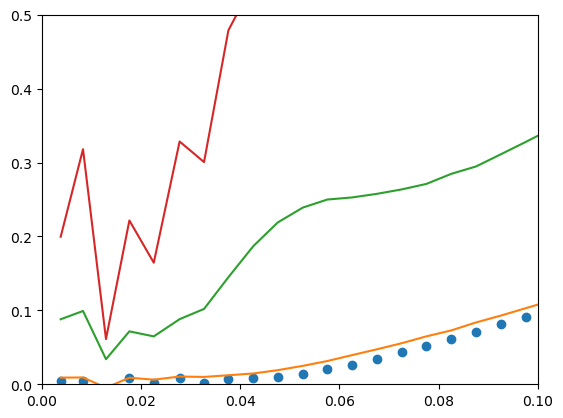

In [69]:
plt.plot(ks, ev_array[:,0], 'o')
plt.plot(ks, ev_array[:,1])
plt.plot(ks, ev_array[:,2])
plt.plot(ks, ev_array[:,3])
plt.plot(ks, ev_array[:,4])
plt.plot(ks, ev_array[:,5])
plt.plot(ks, ev_array[:,6])

plt.xlim(0, 0.1)
plt.ylim(0,0.5)

(0.0, 0.05)

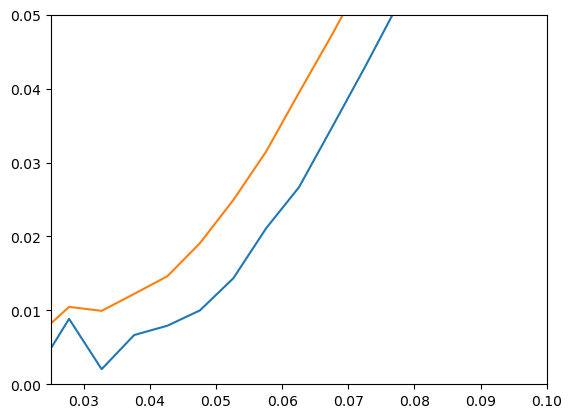

In [63]:
plt.plot(ks, ev_array[:,0])
plt.plot(ks, ev_array[:,1])
#plt.plot(ks, ev_array[:,2])
#plt.plot(ks, ev_array[:,3])
#plt.plot(ks, ev_array[:,4])
#plt.plot(ks, ev_array[:,5])
#plt.plot(ks, ev_array[:,6])

#plt.plot(ks, np.sum(ev_array,axis=1))

plt.xlim(0.025,0.1)
plt.ylim(0,0.05)

In [ ]:
plt.plot(ks, ev_array[:,0])
plt.plot(ks, ev_array[:,1])

#plt.plot(ks, np.sum(ev_array,axis=1))

plt.xlim(0,0.2)

plt.ylim(0,0.3)

In [ ]:
np.dot(np.linalg.inv(cov), cov)

In [ ]:
errs = np.diag(cov)**0.5

corr = cov / errs[None,:] / errs[:,None]

evals, evecs = np.linalg.eig(corr)

iis = np.argsort(evals)

evals[iis]

plt.plot(evecs[:,iis][:,0])

In [ ]:
evals[evals < 0.1] = 0.1
D = np.diag(evals)
V = evecs
V_inv = np.linalg.inv(V)
corr_reconstructed = V @ D @ V_inv

cov_reconstructed = corr_reconstructed * errs[:, None] * errs[None,:]

In [ ]:
plt.figure(figsize=(10,10))


plt.imshow(corr_reconstructed - corr, vmin=-0.1, vmax=0.1, cmap='seismic')
plt.colorbar()

In [ ]:
np.min(corr_reconstructed - corr)

In [ ]:
np.savetxt('/pscratch/sd/s/sfschen/abacus_pvs/pvs/AbacusSummit_base_c000_z0.100_12.5_13.0_xins_rsd_cov_reconstructed.txt', cov_reconstructed)

In [ ]:
np.savetxt('/pscratch/sd/s/sfschen/abacus_pvs/pvs/AbacusSummit_base_c000_z0.100_12.5_13.0_xins_rsd_cov_gp.txt', cov)

In [ ]:
np.linalg.slogdet(ncov[indx,indy])

In [ ]:
kiis = ks > 0.035
inds = np.concatenate((kiis,)*Nvec)

indx, indy = np.ix_( inds, inds)

np.linalg.slogdet(cov[indx,indy])

In [ ]:
np.linalg.slogdet(cov_noisy[indx,indy])

In [ ]:
errs = np.diag(cov)**0.5

corr = cov / errs[:,None] / errs[None,:]

In [ ]:
corr[np.isnan(corr)] = 1e20

In [ ]:
evals, evecs = np.linalg.eig(corr)

In [ ]:
plt.hist(evals,bins=30)

In [ ]:
iis = np.argsort(evals)
evals[iis]

plt.plot(evecs[:,iis][:,80])

In [ ]:
eigenvalues = np.linalg.eigvalsh(corr[indx,indy])

print("Smallest eigenvalues:", np.sort(eigenvalues)[:5])
print("Condition number (max/min eigenvalue):", np.max(eigenvalues) / np.min(eigenvalues))


In [ ]:
plt.figure(figsize=(10,10))

plt.imshow((cov - cov_noisy) /  errs[:,None] / errs[None,:], vmin = -0.5, vmax= 0.5, cmap='seismic' )

plt.colorbar()

In [ ]:
plt.plot(np.diag(cov-cov_noisy)/errs**2,'o')

plt.ylim(-0.1,0.1)

In [ ]:
prod[0]

In [ ]:
a = compute_spectrum_from_multipoles(mus, p1) * compute_spectrum_from_multipoles(mus, p2)

In [ ]:
a.shape

In [ ]:
a[:,0]